In [266]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
import numpy as np
import pandas as pd
import os
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import normalize
%matplotlib inline

In [267]:
data = pd.read_csv(os.path.join(DATA_PATH,'BOD_biclass_139rdkit.csv'))
data_139 = data.iloc[:,2:141]
data_train = data_139.values
data_train.shape
data_train = normalize(data_train, axis=0, order=2)

(array([419.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 644.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

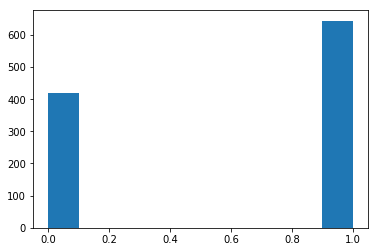

In [268]:
true_label_biclass = data['bod_class'].values
plt.hist(true_label_biclass)

In [269]:
from dimreducer import DeepAutoEncoder
from cluster import KMeansLayer
from keras import Model

In [270]:
dims = [139,100,70,50]
autoencoder =  DeepAutoEncoder(dims)
autoencoder.build_autoencoder()
autoencoder.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 139)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 139)               556       
_________________________________________________________________
encoder_0 (Dense)            (None, 100)               14000     
_________________________________________________________________
encoder_1 (Dense)            (None, 70)                7070      
_________________________________________________________________
embedding_layer (Dense)      (None, 50)                3550      
_________________________________________________________________
decoder_2 (Dense)            (None, 70)                3570      
_________________________________________________________________
decoder_1 (Dense)            (None, 100)               7100      
__________

In [271]:
embeding   = autoencoder.model.get_layer(name='embedding_layer').output
encoder    = Model(inputs=autoencoder.model.input, outputs=embeding)
n_clusters = 2
alpha      = 1.0
clustering = KMeansLayer(n_clusters, alpha=alpha, name='clustering')(embeding)
model      = Model(inputs=autoencoder.model.input, outputs=[clustering,autoencoder.model.output])

In [272]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 139)          0                                            
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 139)          556         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 100)          14000       batch_normalization_17[0][0]     
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 70)           7070        encoder_0[0][0]                  
__________________________________________________________________________________________________
embedding_

In [273]:
model.compile(loss={'clustering': 'kld', 'decoder_output': 'mse'},
              loss_weights=[0.05, 1],optimizer='adam')

In [274]:
from cluster import KMeans

def target_distribution(q):  # target distribution P which enhances the discrimination of soft label Q
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [275]:
kmeans_init = KMeans(n_clusters=2)
kmeans_init.bulid_kmeans_cluster()
kmeans_init.model.fit(encoder.predict(data_train))
y_pred_last = kmeans_init.model.labels_
model.get_layer(name='clustering').set_weights([kmeans_init.model.cluster_centers_])

In [ ]:
update_interval = 200
maxiter = 1e4
tol = 1e-4
loss = []
delta_label = []
for iteration in range(int(maxiter)):
    if iteration % update_interval == 0:
        q, _ = model.predict(data_train)
        p = target_distribution(q)
        y_pred = q.argmax(1)
        delta_label_i = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        delta_label.append(delta_label_i)
        y_pred_last = y_pred
    
#     if iteration > 200 and delta_label_i < tol:  
#         print(str(delta_label_i) +' < ' + str(tol))
#         print('Reached tolerance threshold. Stopping training.')
#         break
    
    loss_tmp = model.train_on_batch(x=data_train, y=[p,data_train])
    loss.append(loss_tmp)
    if iteration % update_interval == 0:
        print('Epoch: ' + str(iteration))
        print('total_loss = ' + str(loss_tmp[0]) + '; clustering_loss = ' +
              str(loss_tmp[1]) + '; decoder_loss = ' + str(loss_tmp[2]) + 
              '; delta_label = ' + str(delta_label_i))
    



Epoch: 0
total_loss = 0.0043204646; clustering_loss = 0.0004434892; decoder_loss = 0.0042982902; delta_label = 0.0
Epoch: 200
total_loss = 0.00026002282; clustering_loss = 1.3000048e-05; decoder_loss = 0.0002593728; delta_label = 0.1458137347130762
Epoch: 400
total_loss = 0.0001742341; clustering_loss = 4.8867376e-05; decoder_loss = 0.00017179073; delta_label = 0.12229539040451552
Epoch: 600
total_loss = 0.00014492864; clustering_loss = 0.00019184072; decoder_loss = 0.0001353366; delta_label = 0.05174035747883349
Epoch: 800
total_loss = 0.0001548186; clustering_loss = 0.0007557459; decoder_loss = 0.0001170313; delta_label = 0.04045155221072436
Epoch: 1000
total_loss = 0.0002528918; clustering_loss = 0.0029079404; decoder_loss = 0.00010749478; delta_label = 0.017873941674506115
Epoch: 1200
total_loss = 0.00061388925; clustering_loss = 0.010253667; decoder_loss = 0.00010120589; delta_label = 0.004703668861712135
Epoch: 1400
total_loss = 0.0015199466; clustering_loss = 0.028523695; decode

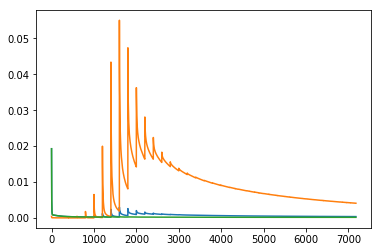

In [261]:
plt.plot(loss)

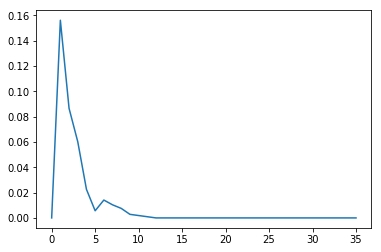

In [262]:
plt.plot(delta_label)

(array([523.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 540.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

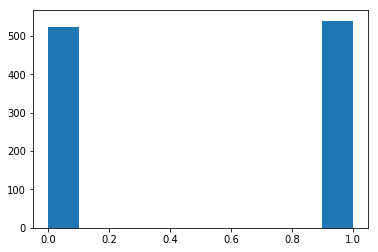

In [263]:
plt.hist(y_pred)

In [264]:
from cluster import Cluster
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)

Metric with True label
adjusted rand score: -0.0008043114252724529 
adjusted mutual info score: -0.0006435493726388063
homogeneity completeness v measure:
(3.785520439515682e-05, 3.662925907760417e-05, 3.723214277385357e-05)
fowlkes_mallows : 0.5102888666823187


/Users/hanghu/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


{'adjusted_rand_score': -0.0008043114252724529,
 'adjusted_mutual_info_score': -0.0006435493726388063,
 'homogeneity_completeness_v_measure': (3.785520439515682e-05,
  3.662925907760417e-05,
  3.723214277385357e-05),
 'fowlkes_mallows_score': 0.5102888666823187}

In [265]:
np.count_nonzero(true_label_biclass == y_pred)

537